<a href="https://colab.research.google.com/github/ADGGi/CP1/blob/main/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
myfile = files.upload()

Saving model_data.csv to model_data.csv


In [ ]:
#데이터 불러오기
import numpy as np
import pandas as pd

X_train = np.load('/content/drive/MyDrive/project1/dataset/arrayset/X_train.npy')
X_test = np.load('/content/drive/MyDrive/project1/dataset/arrayset/X_test.npy')

y_train = np.load('/content/drive/MyDrive/project1/dataset/arrayset/y_train.npy')
y_test = np.load('/content/drive/MyDrive/project1/dataset/arrayset/y_test.npy')

df = pd.read_csv('/content/model_data.csv')
df = df[['comments', 'label']]
print('data shape :', df.shape)

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

print('\nX_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

data shape : (53174, 2)
X_train shape : (42539, 400)
y_train shape : (42539,)

X_test shape : (10635, 400)
y_test shape : (10635,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

train_token = pd.read_csv('/content/drive/MyDrive/project1/train_token.csv')

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_token['comments'].astype(str))
vocab=tokenizer.word_index

vocab_size = len(vocab)
embedding_dim = 128
max_len = 400
n_class = 2

In [ ]:
import tensorflow.keras.backend as K

def mish(x):
  return x + K.tanh(K.softplus(x))

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Flatten, MaxPool1D, GlobalAveragePooling1D

In [ ]:
cnn_1d = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_len),
                     Dropout(0.3),
                     Conv1D(50, 3, padding='same', activation=mish, strides=1),
                     GlobalMaxPooling1D(),
                     Flatten(),
                     Dropout(0.3),
                     Dense(50, activation=mish),
                     Dense(1, activation='sigmoid')
])

cnn_1d.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
cnn_1d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 128)          14217984  
                                                                 
 dropout_2 (Dropout)         (None, 400, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 400, 50)           19250     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
#교차검증
n_fold = 3
seed = 722

cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

#예측값 공간
y_prob = np.zeros((X_test.shape[0], 1))

#조기종료
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3,
                   verbose = 1, mode = min, baseline = None, restore_best_weights=True)

k=0
for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1) :
  print('{}번째 교차검증'.format(k+1))

  cnn_1d.fit(X_train[i_trn],
             y_train[i_trn],
             validation_data=(X_train[i_val], (y_train[i_val])),
             epochs = 10,
             batch_size = 256,
             callbacks=[es])
  
  y_prob += cnn_1d.predict(X_test)
  k += 1

1번째 교차검증
Epoch 1/10
111/111 [==============================] - 15s 56ms/step - loss: 0.3660 - accuracy: 0.8752 - val_loss: 0.2356 - val_accuracy: 0.9131
Epoch 2/10
111/111 [==============================] - 6s 52ms/step - loss: 0.1667 - accuracy: 0.9360 - val_loss: 0.2408 - val_accuracy: 0.9140
Epoch 3/10
111/111 [==============================] - 6s 52ms/step - loss: 0.0811 - accuracy: 0.9697 - val_loss: 0.3131 - val_accuracy: 0.9033
Epoch 4/10
111/111 [==============================] - 6s 53ms/step - loss: 0.0469 - accuracy: 0.9835 - val_loss: 0.3754 - val_accuracy: 0.9042
Epoch 00004: early stopping
2번째 교차검증
Epoch 1/10
111/111 [==============================] - 6s 53ms/step - loss: 0.2119 - accuracy: 0.9224 - val_loss: 0.1716 - val_accuracy: 0.9314
Epoch 2/10
111/111 [==============================] - 6s 51ms/step - loss: 0.0940 - accuracy: 0.9654 - val_loss: 0.1884 - val_accuracy: 0.9286
Epoch 3/10
111/111 [==============================] - 6s 52ms/step - loss: 0.0479 - accuracy: 0

In [ ]:
import matplotlib.pyplot as plt

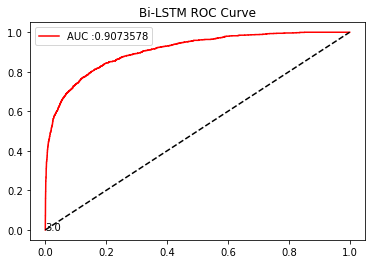

In [ ]:
fpr, tpr, thr = roc_curve(y_test, y_prob)

idx_list = np.arange(1, len(thr), 2000)

plt.plot(fpr, tpr,
        c = 'red',
        label = "AUC :"+str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0,1], [0,1], ls='--', c='black')
plt.title("Bi-LSTM ROC Curve")
plt.legend(loc=0)
for idx in idx_list:
  text = str(round(thr[idx], 2))
  plt.text(fpr[idx], tpr[idx], text)

In [ ]:
data = {'fpr' : fpr,
        'tpr' : tpr,
        'thr' : thr}

dff = pd.DataFrame(data)

dff.to_csv('/content/drive/MyDrive/project1/DeepLearning/1d_cnn_roc_curve')

In [ ]:
cnn_1d.save('1d_cnn.h5')